# MNIST Convolutional Autoencoder with Weighted Likelihood Bootstrap

___

Adapted from: https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pdb

# TERMINAL:  tensorboard --logdir=/tmp/autoencoder

Using TensorFlow backend.


#### Make plotting utility function.

In [2]:
def plot_results(autoencoder, x_test, weights=None):
    if weights:
        decoded_imgs = autoencoder.predict([x_test, weights])
    else:
        decoded_imgs = autoencoder.predict(x_test)
        
    n = 10
    plt.figure(figsize=(20, 4))
    random_set_to_show = range(10)
    for position, random_index in enumerate(random_set_to_show):
        # display original
        ax = plt.subplot(2, n, position + 1)
        plt.imshow(x_test[random_index].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, position + n + 1)
        plt.imshow(decoded_imgs[random_index].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    return decoded_imgs

#### Load train and test data.

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train[:64]

x_test = x_test.astype('float32') / 255.
x_test = x_test[:64]

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

## BASELINE
Build baseline convolutional model, and train.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 64 samples, validate on 64 samples
Epoch 1/1000
64/64 [==============================] - 1s 10ms/step - loss: 0.6990 - val_loss: 0.6940
Epoch 2/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.6940 - val_loss: 0.6909
Epoch 3/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.6910 - val_loss: 0.6881
Epoch 4/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.6883 - val_loss: 0.6848
Epoch 5/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.6851 - val_loss: 0.6804
Epoch 6/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.6808 - val_loss: 0.6739
Epoch 7/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.6746 - val_loss: 0.6639
Epoch 8/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.6649 - val_loss: 0.6473
Epoch 9/1000
64/64 [===============

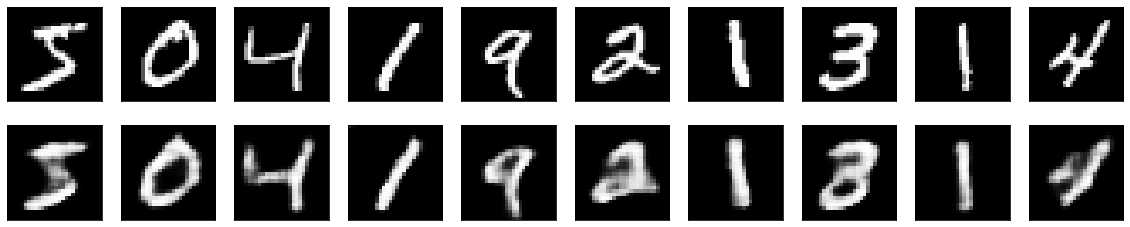

array([[[[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [1.1920929e-07],
         [2.9802322e-07],
         [1.4394522e-05]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [2.8610229e-06]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [2.1457672e-06],
         [3.1292439e-06],
         [5.8114529e-05]],

        ...,

        [[0.0000000e+00],
         [0.0000000e+00],
         [2.9802322e-08],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[3.5762787e-07],
         [0.0000000e+00],
         [1.7881393e-07],
         ...,
         [0.0000000e+00],
        

In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


autoencoder.fit(x_train, x_train,
                epochs=1000,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))
plot_results(autoencoder, x_train)

## Weighted Likelihood Bootstrap
Redefine TensorFlow backend binary_crossentropy to apply random exponential weights.

In [5]:
# Pointer to hint on custom loss function in Keras.
# https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras
# https://github.com/keras-team/keras/blob/5a7a789ee9766b6a594bd4be8b9edb34e71d6500/keras/losses.py#L76

def wlb_binary_crossentropy(exp_weights):
    # Weight loss with random exponential weights over true points.
    # Workaround to get exponential random variables of batch size (without TFProbability).
    
    #exp_weights = -1 * tf.log(tf.random.uniform(shape=(tf.shape(y_true)[0], 1)))
    #exp_weights = exp_weights[tf.newaxis, tf.newaxis, :, 0]
    #exp_weights = tf.tile(exp_weights, [y_pred.shape[1], y_pred.shape[1], 1])
    #exp_weights = tf.transpose(exp_weights, [2, 0, 1])
    #return K.mean(binary_crossentropy(y_true, y_pred), axis=-1)
    
    def wlb_loss(y_true, y_pred):
        #return exp_weights * tf.reduce_mean(binary_crossentropy(y_true, y_pred), axis=-1)
        return (tf.reduce_mean(exp_weights, axis=-1) *
                tf.reduce_mean(binary_crossentropy(y_true, y_pred), axis=[1, 2, 3]))
    
    return wlb_loss


def binary_crossentropy(target, output):
    """Binary crossentropy between an output tensor and a target tensor.
    
    Arguments
      target: A tensor with the same shape as `output`.
      output: A tensor.

    Returns
      A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    # transform back to logits
    _epsilon = tf.convert_to_tensor(1e-07, output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))

    return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                   logits=output)

Build convolutional model with WLB loss.

In [6]:
def build_wlb_model():
    input_img = Input(shape=(28, 28, 1), name='wlb_img')  # adapt this if using `channels_first` image data format
    input_w = Input(shape=(1,), name='wlb_w')

    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='c1')(input_img)
    x = MaxPooling2D((2, 2), padding='same', name='m1')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='c2')(x)
    x = MaxPooling2D((2, 2), padding='same', name='m2')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='c3')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='m3')(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='c4')(encoded)
    x = UpSampling2D((2, 2), name='u4')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='c5')(x)
    x = UpSampling2D((2, 2), name='u5')(x)
    x = Conv2D(16, (3, 3), activation='relu', name='c6')(x)  # No padding here goes from 16x16 to 14x14.
    x = UpSampling2D((2, 2), name='u6')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='c7')(x)

    autoencoder_wlb = Model(inputs=[input_img, input_w], outputs=[decoded])

    # New loss.
    autoencoder_wlb.compile(optimizer='adadelta',
                            loss=wlb_binary_crossentropy(input_w))
    
    return autoencoder_wlb

## Experiment with WLB.

In [7]:
num_samples = 5
batch_size = 64
num_epochs = 1000
all_test_ae = []

In [8]:
for _ in range(num_samples):
    exp_weights = np.random.exponential(scale=1, size=[batch_size,])
    print(exp_weights)

    autoencoder_wlb = build_wlb_model()
    autoencoder_wlb.fit([x_train, exp_weights], [x_train],
                         epochs=num_epochs,
                         batch_size=batch_size,
                         shuffle=True,
                         validation_data=([x_test, exp_weights], x_test),
                         verbose=0,
                       )

    test_ae = autoencoder_wlb.predict([x_train, exp_weights])
    all_test_ae.append(test_ae)
    
    del autoencoder_wlb

[0.41975917 0.88491868 0.81756559 0.42841473 0.04681241 0.3699477
 0.06996269 0.0645345  0.71948066 0.93752943 0.36211976 0.67249429
 0.91234578 0.87879032 0.22564807 0.05976964 0.87762496 0.24999709
 0.62719497 0.1434225  0.05071683 2.12579705 0.66128515 0.81554601
 0.58768081 0.9695628  0.39387486 1.75821268 2.3334021  0.16383272
 0.07590401 0.56231171 0.09300284 0.16745744 1.95109723 0.16223225
 0.67231998 0.09917619 3.15749418 0.42993785 0.0482977  0.31456879
 1.66007036 1.20956699 2.3483568  0.99632205 2.23538147 0.27622601
 2.68996858 0.2860206  2.4543203  1.55415961 0.95942469 1.17258713
 0.75487154 0.14765417 2.77503866 0.33651925 3.6871205  0.54750281
 0.57611114 0.51532967 3.63583093 5.09638389]
[1.47413154 1.04292582 0.30146903 1.09536894 1.55206891 0.25905271
 0.30816089 0.77878001 1.00246788 0.37701464 2.77570153 0.57811676
 0.26655168 0.77350376 0.50790924 1.84854369 1.27806805 3.15569914
 0.38300389 0.91752052 0.13200225 0.20939736 0.39335881 2.21003547
 1.55675845 0.720

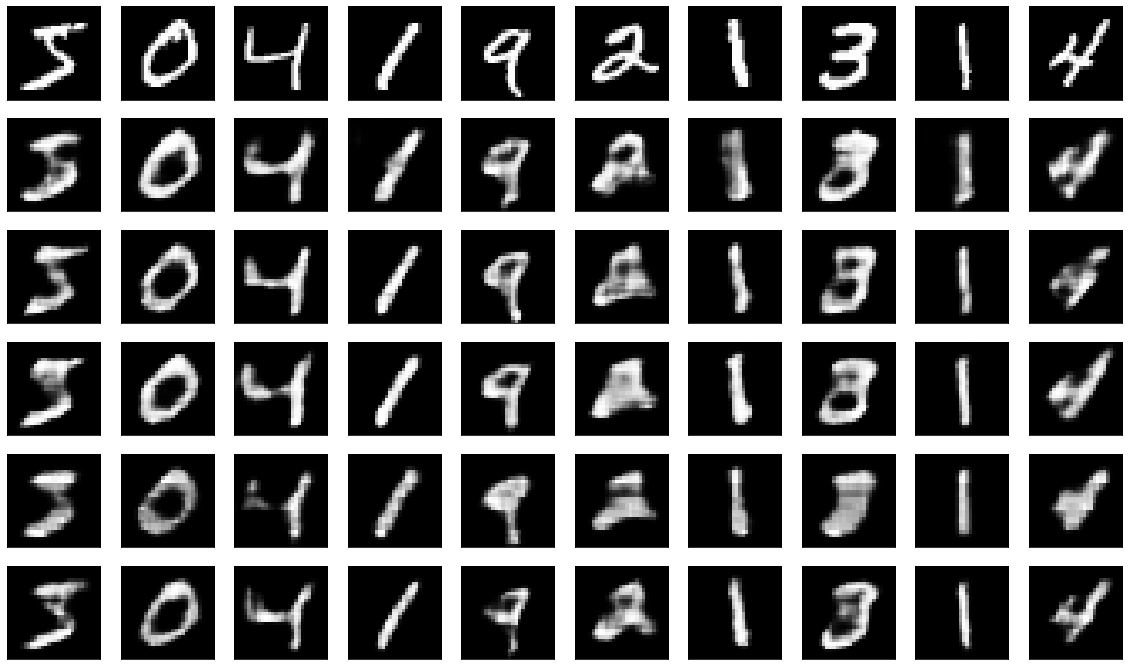

In [9]:
n = 10
num_rows = num_samples + 1
num_cols = n

#plt.figure(figsize=(20, 12))
plt.figure(figsize=(num_cols * 2, num_rows * 2))
set_to_show = range(10)

# display original
for position, set_index in enumerate(set_to_show):
    ax = plt.subplot(num_rows, num_cols, position + 1)
    plt.imshow(x_train[set_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i in range(num_samples):
    decoded_imgs = all_test_ae[i]
    for position, set_index in enumerate(set_to_show):
        # display reconstruction
        ax = plt.subplot(num_rows, num_cols, num_cols * (i + 1) + position + 1)
        plt.imshow(decoded_imgs[set_index].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()


___